<a href="https://colab.research.google.com/github/nicolasvazquez95/Aprendiendo_DeepLearning/blob/main/projects/02_SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available in [arXiv](https://arxiv.org/abs/1710.06071).

The model architecture that they use is available here: https://arxiv.org/abs/1612.05251


## Confirm access to a GPU

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f00957af-0005-1e79-de45-0996c37cf906)


## Get data
Let's download the dataset they used. It's freely available in GitHub

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [ ]:
!tail pubmed-rct/PubMed_20k_RCT/test.txt

METHODS	Both were assessed at baseline , 3 weeks , and 6 weeks .
METHODS	Treatment satisfaction was assessed at week 6 .
METHODS	Adverse effects were also monitored .
RESULTS	There was a statistically significant within-group improvement in VISA-A score for both groups ( standard , P = .03 ; do as tolerated , P < .001 ) and VAS pain for the do-as-tolerated group ( P = .001 ) at week 6 , based on the intention-to-treat analysis .
RESULTS	There was a statistically significant between-group difference in VISA-A scores at week 3 , based on both the intention-to-treat ( P = .004 ) and per-protocol analyses ( P = .007 ) , partly due to a within-group deterioration at week 3 in the standard group .
RESULTS	There were no statistically significant between-group differences for VISA-A and VAS pain scores at week 6 , the completion of the intervention .
RESULTS	There was no significant association between satisfaction and treatment groups at week 6 .
RESULTS	No adverse effects were reported .
CON

We'll start the experiments using the small dataset (20k) with the numbers replaced with `'@'`.

In [4]:
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
import os 
filenames = [data_dir+filename for filename in os.listdir(data_dir)]

## Preprocess data

In [23]:
def get_text(filename):
  with open(filename,'r') as f:
    return f.readlines()
test = get_text(filenames[0])
train = get_text(filenames[1])
dev = get_text(filenames[2])

__How can we represent this data?__

We can use a dictionary format with the keys: `line_number, target, text`. Our samples will be in a list of dictionaries, one for each line in the text.

In [24]:
def get_list_samples(file):
  """This function receives a written file loaded in memory (i.e. a list of strings). Then it returns the samples in the format required,
  if the lines are in the format
  SECTION\t\PHRASE\n
  It returns a list of dictionaries with the lines preprocessed.
  """
  list_of_samples = []
  for line in file:
     # Need to filter number of the paper, and empty lines
    if line.startswith('###'):
      n_line = 0
      article_id = line[3:-2]
    elif line.startswith('\n'):pass
    else: 
      # Find the target in the string
      index_t = line.index('\t')
      index_n = line.index('\n')
      target = line[:index_t]
      text = line[index_t+1:index_n]
      n_line += 1
      list_of_samples.append({'n_line':n_line,'target':target,
                              'text':text,'article_id':article_id})
  return list_of_samples

In [25]:
train_list = get_list_samples(train)
test_list = get_list_samples(test)
dev_list = get_list_samples(dev)

In [8]:
test_list[:2]

[{'article_id': '2484596',
  'n_line': 1,
  'target': 'BACKGROUND',
  'text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .'},
 {'article_id': '2484596',
  'n_line': 2,
  'target': 'RESULTS',
  'text': 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .'}]

In this format, we can turn the data into a DataFrame

In [26]:
import pandas as pd
train = pd.DataFrame(train_list)
test = pd.DataFrame(test_list)
dev = pd.DataFrame(dev_list)

In [30]:
train.head()

,n_line,target,text,article_id
0,1,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,2429357
1,2,METHODS,A total of @ patients with primary knee OA wer...,2429357
2,3,METHODS,Outcome measures included pain reduction and i...,2429357
3,4,METHODS,Pain was assessed using the visual analog pain...,2429357
4,5,METHODS,Secondary outcome measures included the Wester...,2429357


In [ ]:
# Distribution of labels in training data
train.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [11]:
num_classes = len(train.target.value_counts())

In [15]:
X_train = train['text'].tolist()
X_test = test['text'].tolist()
X_dev = dev['text'].tolist()
print(len(X_train),len(X_test),len(X_dev))

180040 30135 30212


In [68]:
# One-hot-encoder for the targets
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder(sparse=False)
OHE.fit(train.target.to_numpy().reshape(-1,1))
y_train = OHE.transform(train.target.to_numpy().reshape(-1,1))
y_test = OHE.transform(test['target'].to_numpy().reshape(-1,1))
y_dev = OHE.transform(dev['target'].to_numpy().reshape(-1,1))
for target,number in zip(train.target.tolist()[5:8],y_train[5:8]):
  print(target,number)

METHODS [0. 0. 1. 0. 0.]
RESULTS [0. 0. 0. 0. 1.]
RESULTS [0. 0. 0. 0. 1.]


# Starting a series of modelling experiments

## Baseline model (SKLearn)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create pipeline
model_0 = Pipeline([('tf-idf',TfidfVectorizer()),
                    ('clf',MultinomialNB())])

# Fit pipeline to the training data
model_0.fit(X=X_train,y=y_train.argmax(axis=1))

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
#Evaluate on the test dataset
print(model_0.score(X=X_test,y=y_test.argmax(axis=1)))
# Get predictions for more metrics 
baseline_predictions = model_0.predict(X_test)

0.716674962667994


In [11]:
# Use the helper script for the F1 metrics
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-31 18:57:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2022-05-31 18:57:40 (15.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results
calculate_results(y_true=y_test.argmax(axis=1),y_pred=baseline_predictions)

{'accuracy': 71.6674962667994,
 'f1': 0.6925101703856846,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994}

# Deep Learning models


## TextVectorizer + Embedding layer

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

In [ ]:
# Length of sentences we're working with
sent_lens = [len(sentence.split()) for sentence in X_train]
np.mean(sent_lens),np.std(sent_lens)

(26.338269273494777, 15.38676065622758)

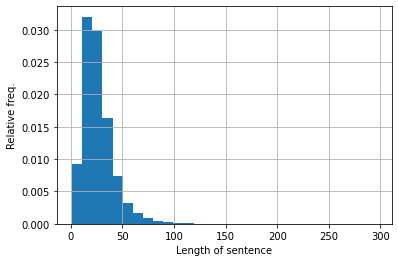

In [ ]:
from matplotlib import pyplot as plt
plt.hist(sent_lens,bins=30,density=True,cumulative=False)
plt.grid()
plt.xlabel('Length of sentence');plt.ylabel('Relative freq.')
plt.show()

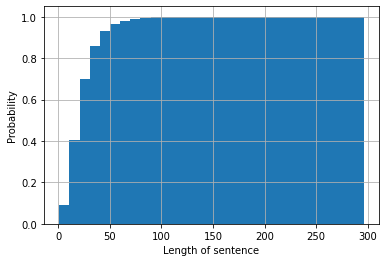

(122, 296)

In [ ]:
# Cumulative probability distribution of the sentences
plt.hist(sent_lens,bins=30,density=True,cumulative=True)
plt.grid()
plt.xlabel('Length of sentence');plt.ylabel('Probability')
plt.show()
# How long of a sentence covers 99.9% of the examples?
# How long is the longest sentence in the training set?
int(np.percentile(sent_lens,99.9)), max(sent_lens)

In [ ]:
# Text Vectorization layer
len(X_train)
# In the paper (https://arxiv.org/pdf/1710.06071v1.pdf), the authors of the dataset state
# that the vocabulary length is ~68k
max_tokens = 68000

text_vectorizer = layers.experimental.preprocessing.TextVectorization(max_tokens,
                                                                      output_sequence_length=122)
# Adapt to the training sequences
text_vectorizer.adapt(X_train)

In [ ]:
import random
random_sentence = random.choice(X_train)
print(f'Text:\n{random_sentence}')
print(f'Length of text:{len(random_sentence)}')
print(f'Vectorized text:\n{text_vectorizer([random_sentence])}')

Text:
It is unclear whether thiazide diuretics ( TZs ) or calcium channel blockers ( CCBs ) are more effective as add-on therapy to angiotensin receptor blockers ( ARBs ) in controlling hypertension .
Length of text:194
Vectorized text:
[[  185    20  1288   180 15354  8477 33458    16   826  7732  3638 23652
     58    69   137    25  2040    66     6  3641   746  3638 10873     5
   1708   659     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]]


In [ ]:
# Words of our vocabulary
text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(text_vocab)}')
print(f'5 most common words in the vocab: {text_vocab[:5]}')
print(f'5 least common words in the vocab: {text_vocab[-5:]}')

Number of words in vocab: 64841
5 most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
5 least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Config of the vocabulary
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 122,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Create custom text embedding


In [ ]:
embedding_layer = layers.Embedding(input_dim=len(text_vocab),
                                   output_dim=512,
                                   mask_zero=True,
                                   name='embedding_layer')

## Creating datasets
_Loading our data as fast as possible..._

In [13]:
# We'll use the tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
dev_dataset = tf.data.Dataset.from_tensor_slices((X_dev,y_dev))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_dataset = dev_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: CONV1D + Token Embeddings

In [ ]:
# Create model
inputs = layers.Input(shape=(1,),dtype='string')
x = text_vectorizer(inputs)
x = embedding_layer(x)
x = layers.Conv1D(128,kernel_size=5,padding='same',activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)
model_1 = keras.Model(inputs,outputs)
# Compile model and summary
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',metrics=['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 122)              0         
 torization)                                                     
                                                                 
 embedding_layer (Embedding)  (None, 122, 512)         33198592  
                                                                 
 conv1d (Conv1D)             (None, 122, 128)          327808    
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 645   

In [ ]:
history_model_1 = model_1.fit(train_dataset,
                              epochs=5,
                              validation_data=dev_dataset)

Epoch 1/5
5627/5627 [==============================] - 142s 23ms/step - loss: 0.5985 - accuracy: 0.7825 - val_loss: 0.5306 - val_accuracy: 0.8092
Epoch 2/5
5627/5627 [==============================] - 130s 23ms/step - loss: 0.4333 - accuracy: 0.8481 - val_loss: 0.5359 - val_accuracy: 0.8099
Epoch 3/5
5627/5627 [==============================] - 130s 23ms/step - loss: 0.3347 - accuracy: 0.8870 - val_loss: 0.5985 - val_accuracy: 0.8053
Epoch 4/5
5627/5627 [==============================] - 129s 23ms/step - loss: 0.2501 - accuracy: 0.9190 - val_loss: 0.7097 - val_accuracy: 0.7918
Epoch 5/5
5627/5627 [==============================] - 129s 23ms/step - loss: 0.1850 - accuracy: 0.9422 - val_loss: 0.8469 - val_accuracy: 0.7815


From the 3rd epoch, the model is overfitting...

### Using pre trained layers for the 2nd model

We'll download the `Universal Sentence Encoder` emmbedding layer, which is available on Tensorflow Hub: https://tfhub.dev/google/universal-sentence-encoder/4

In [13]:
import tensorflow_hub
USE_embedding_layer = tensorflow_hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                                trainable=False,
                                                name='USE')

## Model 2 : Conv1D + pretrained embedding layer

In [ ]:
inputs = layers.Input(shape=[],dtype='string')
x = USE_embedding_layer(inputs)
x = layers.Dense(128,activation='relu')(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)

model_2 = keras.Model(inputs,outputs,name='model2_USE')

# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

model_2.summary()

Model: "model2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit
history_model_2 = model_2.fit(train_dataset,
                              validation_data=dev_dataset,
                              epochs=5)

Epoch 1/5
5627/5627 [==============================] - 79s 13ms/step - loss: 0.7280 - accuracy: 0.7221 - val_loss: 0.6577 - val_accuracy: 0.7489
Epoch 2/5
5627/5627 [==============================] - 72s 13ms/step - loss: 0.6360 - accuracy: 0.7590 - val_loss: 0.6225 - val_accuracy: 0.7621
Epoch 3/5
5627/5627 [==============================] - 70s 12ms/step - loss: 0.6008 - accuracy: 0.7720 - val_loss: 0.6074 - val_accuracy: 0.7683
Epoch 4/5
5627/5627 [==============================] - 70s 12ms/step - loss: 0.5780 - accuracy: 0.7811 - val_loss: 0.6005 - val_accuracy: 0.7709
Epoch 5/5
5627/5627 [==============================] - 70s 12ms/step - loss: 0.5612 - accuracy: 0.7880 - val_loss: 0.5980 - val_accuracy: 0.7714


### Next step: Character-level embedding

In [64]:
# Make a function to split sentences into characters
def split_chars(text):
  return ' '.join(list(text))

In [65]:
X_train_chars = [split_chars(sentence) for sentence in X_train]
X_test_chars = [split_chars(sentence) for sentence in X_test]
X_dev_chars = [split_chars(sentence) for sentence in X_dev]

In [ ]:
# Mean character length
char_lens = [len(char_sentence) for char_sentence in X_train]
np.mean(char_lens)

149.3662574983337

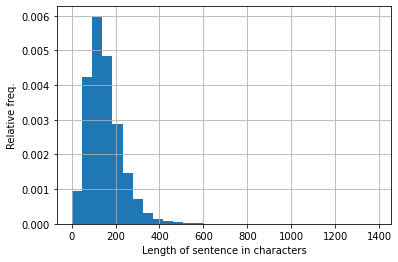

In [ ]:
from matplotlib import pyplot as plt
plt.hist(char_lens,bins=30,density=True,cumulative=False)
plt.grid()
plt.xlabel('Length of sentence in characters');plt.ylabel('Relative freq.')
plt.show()

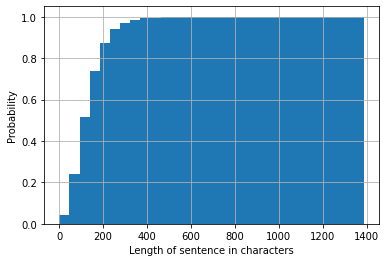

(577, 1386)

In [ ]:
# Cumulative probability distribution of the sentences
plt.hist(char_lens,bins=30,density=True,cumulative=True)
plt.grid()
plt.xlabel('Length of sentence in characters');plt.ylabel('Probability')
plt.show()
# How long of a sentence covers 99.9% of the examples?
# How long is the longest sentence in the training set?
int(np.percentile(char_lens,99.9)), max(char_lens)

In [62]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
print(alphabet)
NUM_TOKENS = len(alphabet) + 2 # 1 for OOV and ' ' 
#Create char_level token vectorizer instance
char_vectorizer = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=NUM_TOKENS,
                                                                            output_sequence_length=577,
                                                                            name='char_vectorizer')

abcdefghijklmnopqrstuvwxyz0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [66]:
char_vectorizer.adapt(X_train_chars)

## Model 3:  Char embedding layer + custom embedding + Conv1D

In [70]:
char_embedding = keras.layers.Embedding(input_dim = len(char_vectorizer.get_vocabulary()),
                                        output_dim = 25,
                                        mask_zero=True,
                                        name='char_embed')

In [ ]:
# Create model
inputs = layers.Input(shape=(1,),dtype='string')
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(128,kernel_size=8,padding='same',activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes,activation='softmax')(x)

model_3 = keras.Model(inputs,outputs,name='model_3_char_embedding')

# Compile
model_3.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [ ]:
# We need to make the datasets for the chars
train_dataset_chars = tf.data.Dataset.from_tensor_slices((X_train_chars,y_train))
test_dataset_chars = tf.data.Dataset.from_tensor_slices((X_test_chars,y_test))
dev_dataset_chars = tf.data.Dataset.from_tensor_slices((X_dev_chars,y_dev))

train_dataset_chars = train_dataset_chars.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_chars = test_dataset_chars.batch(32).prefetch(tf.data.AUTOTUNE)
dev_dataset_chars = dev_dataset_chars.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3_history = model_3.fit(train_dataset_chars,
                              epochs=5,
                              validation_data=dev_dataset_chars)

Epoch 1/5
5627/5627 [==============================] - 45s 6ms/step - loss: 1.3000 - accuracy: 0.4576 - val_loss: 1.2185 - val_accuracy: 0.4998
Epoch 2/5
5627/5627 [==============================] - 35s 6ms/step - loss: 1.1877 - accuracy: 0.5129 - val_loss: 1.1388 - val_accuracy: 0.5343
Epoch 3/5
5627/5627 [==============================] - 36s 6ms/step - loss: 1.0966 - accuracy: 0.5558 - val_loss: 1.0414 - val_accuracy: 0.5836
Epoch 4/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.9998 - accuracy: 0.6042 - val_loss: 0.9561 - val_accuracy: 0.6219
Epoch 5/5
5627/5627 [==============================] - 35s 6ms/step - loss: 0.9252 - accuracy: 0.6385 - val_loss: 0.8947 - val_accuracy: 0.6519


# Model 4 : Hybrid embedding

In [76]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[],dtype='string',name='token_input')
token_embeddings = USE_embedding_layer(token_inputs)
token_output = layers.Dense(128,activation='relu')(token_embeddings)
token_model = keras.Model(token_inputs,token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,),dtype='string',name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings) 
char_model = tf.keras.Model(char_inputs,char_bi_lstm)

# 3. Concatenate token and char inputs 
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])
# 4. Create ouput layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense_layer = layers.Dense(128,activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense_layer)
output_layer = layers.Dense(num_classes,activation='softmax',name='output_layer')(final_dropout)

# 5. Construct model with char and token embeddings
model_4 = keras.Model(inputs=[token_model.input,char_model.input],
                      outputs=output_layer,
                      name='token_and_char_embeddings')

In [26]:
model_4.summary()

Model: "token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 577)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_i

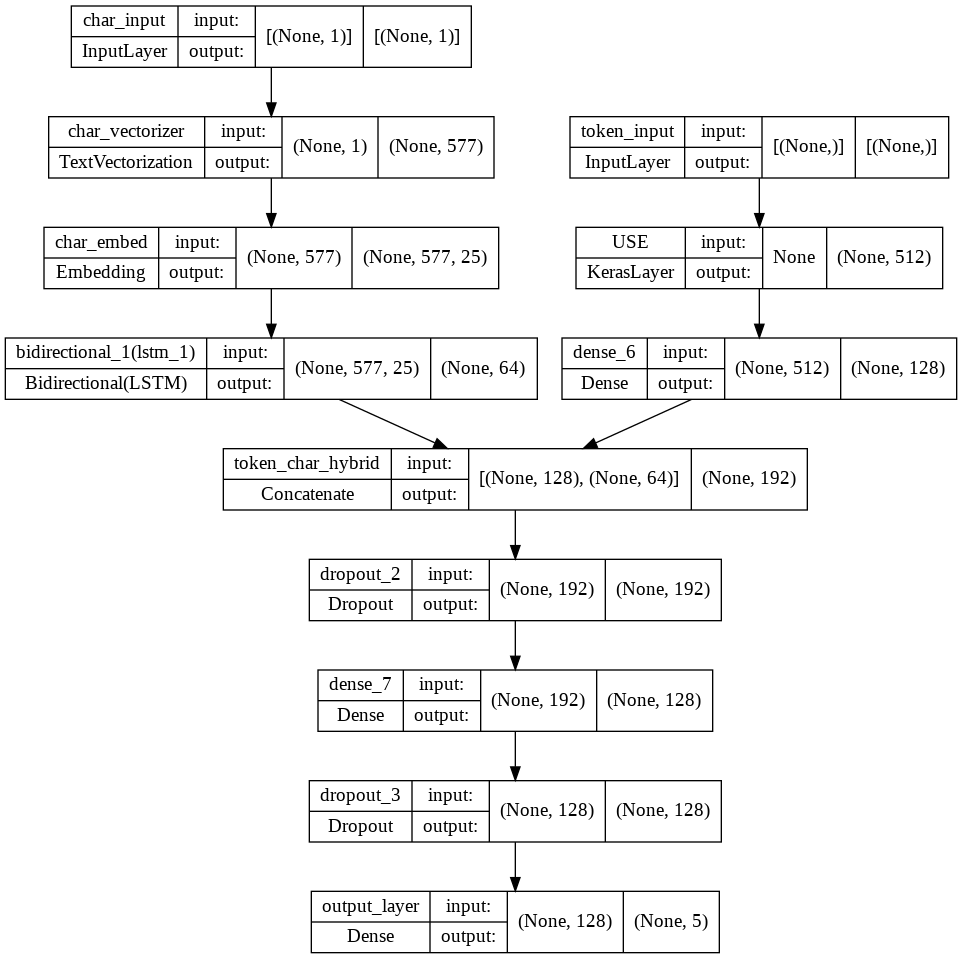

In [77]:
# Plot hybrid token and char model
from keras.utils.vis_utils import plot_model
plot_model(model_4,show_shapes=True)

In [34]:
# Compile token char model 
model_4.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

## A new `tf.Dataset` combining sentences and characters

In [69]:
# Combined datasets for train, test and validation
train_combined = tf.data.Dataset.from_tensor_slices((X_train,X_train_chars))
train_combined_labels = tf.data.Dataset.from_tensor_slices(y_train)
train_combined_dataset = tf.data.Dataset.zip((train_combined,train_combined_labels))

dev_combined = tf.data.Dataset.from_tensor_slices((X_dev,X_dev))
dev_combined_labels = tf.data.Dataset.from_tensor_slices(y_dev)
dev_combined_dataset = tf.data.Dataset.zip((dev_combined,dev_combined_labels))

test_combined = tf.data.Dataset.from_tensor_slices((X_test,X_test))
test_combined_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_combined_dataset = tf.data.Dataset.zip((test_combined,test_combined_labels))

# Prefetch and batch
train_combined_dataset = train_combined_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_combined_dataset = dev_combined_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_combined_dataset = test_combined_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [36]:
model_4.fit(train_combined_dataset,
            epochs=3,
            steps_per_epoch=int(0.25 * len(train_combined_dataset)),
            validation_data=dev_combined_dataset)

Epoch 1/3
1406/1406 [==============================] - 115s 72ms/step - loss: 0.8609 - accuracy: 0.6631 - val_loss: 0.7490 - val_accuracy: 0.7113
Epoch 2/3
1406/1406 [==============================] - 93s 66ms/step - loss: 0.7481 - accuracy: 0.7129 - val_loss: 0.7092 - val_accuracy: 0.7308
Epoch 3/3
1406/1406 [==============================] - 98s 70ms/step - loss: 0.7239 - accuracy: 0.7264 - val_loss: 0.6934 - val_accuracy: 0.7282


## Model 5 : Adding to Model 4 positional embeddings

In [31]:
train.head()

,n_line,target,text,article_id
0,1,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,2429357
1,2,METHODS,A total of @ patients with primary knee OA wer...,2429357
2,3,METHODS,Outcome measures included pain reduction and i...,2429357
3,4,METHODS,Pain was assessed using the visual analog pain...,2429357
4,5,METHODS,Secondary outcome measures included the Wester...,2429357


In [32]:
# Adding a column with the number of lines in the article
train['total_lines'] = train['article_id'].map(train['article_id'].value_counts())
test['total_lines'] = test['article_id'].map(test['article_id'].value_counts())
dev['total_lines'] = dev['article_id'].map(dev['article_id'].value_counts())

In [34]:
train.head()

,n_line,target,text,article_id,total_lines
0,1,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,2429357,12
1,2,METHODS,A total of @ patients with primary knee OA wer...,2429357,12
2,3,METHODS,Outcome measures included pain reduction and i...,2429357,12
3,4,METHODS,Pain was assessed using the visual analog pain...,2429357,12
4,5,METHODS,Secondary outcome measures included the Wester...,2429357,12


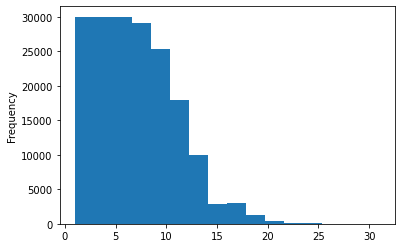

In [58]:
# An histogram for the n_line column
train.n_line.plot.hist(bins=16)

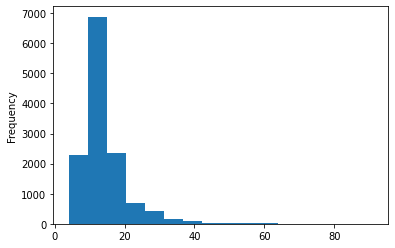

In [59]:
# An histogram for the n_line column
train.article_id.value_counts().plot.hist(bins=16)

In [61]:
# A percentile checking for the depth in the one-hot encoding
np.percentile(train.article_id.value_counts().to_numpy(),98)
# With a depth of 32, we're ok with almost a 98% of the samples

34.0

In [54]:
# One hot encoding for the n_line column
train_n_line_OH = tf.one_hot(train.n_line.to_numpy(),depth=32)
test_n_line_OH = tf.one_hot(test.n_line.to_numpy(),depth=32)
dev_n_line_OH = tf.one_hot(dev.n_line.to_numpy(),depth=32)

In [55]:
# For the total lines, another histogram
train_total_lines_OH = tf.one_hot(train['total_lines'].to_numpy(),depth=32)
test_total_lines_OH = tf.one_hot(test['total_lines'].to_numpy(),depth=32)
dev_total_lines_OH = tf.one_hot(dev['total_lines'].to_numpy(),depth=32)

In [71]:
train_total_lines_OH[0]

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

## Building 

In [73]:
# 1. Token inputs
token_inputs = layers.Input(shape=[],dtype='string',name='token_inputs')
token_embeddings = USE_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation='relu')(token_embeddings)
token_model = keras.Model(token_inputs,token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,),dtype='string',name='char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = keras.Model(char_inputs,char_bi_lstm)

# 3. Line numbers model
n_line_input = layers.Input(shape=(32,),name='n_line_input')
n_line_layer1 = layers.Dense(32,activation='relu')(n_line_input)
n_line_model = keras.Model(n_line_input,n_line_layer1)

# 4. Total lines model
total_lines_input = layers.Input(shape=(32,),name='total_lines_input')
total_lines_layer1 = layers.Dense(32,activation='relu')(total_lines_input)
total_lines_model = keras.Model(total_lines_input,total_lines_layer1)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name='char_token_embedding')([token_model.output,char_model.output])
dense_layer1 = layers.Dense(256,activation='relu')(combined_embeddings)
dropout_layer1 = layers.Dropout(0.5)(dense_layer1)
# 6. Combine positional embeddings with combined and char embeddings
final_embeddings = layers.Concatenate(name='all_embeddings')([n_line_model.output,total_lines_model.output,dropout_layer1])
dense_layer2 = layers.Dense(256,activation='relu')(final_embeddings)
dropout_layer2 = layers.Dropout(0.5)(dense_layer2)

output_layer = layers.Dense(5,activation='softmax')(dropout_layer2)

model_5 = keras.Model([token_model.input,char_model.input,
                       n_line_model.input,total_lines_model.input],
                      output_layer)

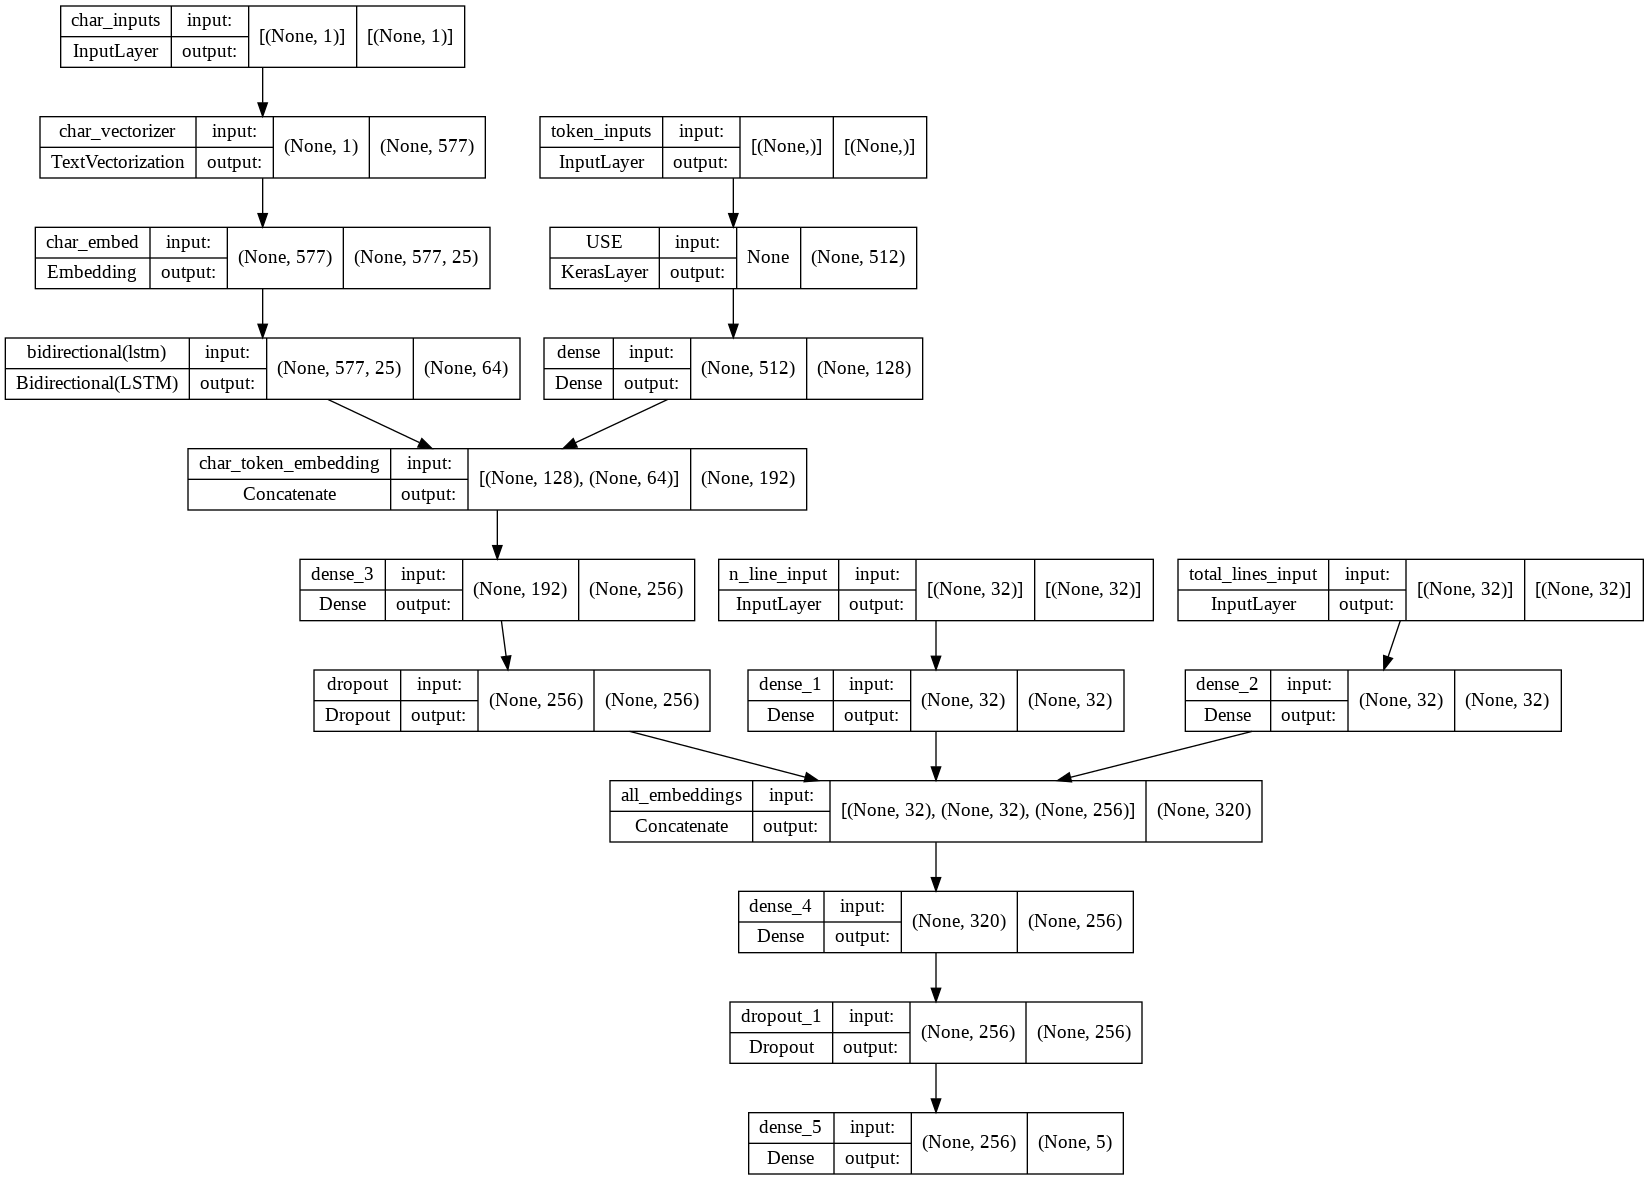

In [79]:
plot_model(model_5,show_shapes=True)

In [80]:
model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 577)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_inputs[0][0]']     

In [81]:
# Compile model 5 with label_smoothing (see https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06)
model_5.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer='Adam',
                metrics=['accuracy'])


In [82]:
# Setting the datasets
# Combined datasets for train, test and validation
train_combined = tf.data.Dataset.from_tensor_slices((X_train,X_train_chars,train_n_line_OH,train_total_lines_OH))
train_combined_labels = tf.data.Dataset.from_tensor_slices(y_train)
train_combined_dataset = tf.data.Dataset.zip((train_combined,train_combined_labels))

dev_combined = tf.data.Dataset.from_tensor_slices((X_dev,X_dev,dev_n_line_OH,dev_total_lines_OH))
dev_combined_labels = tf.data.Dataset.from_tensor_slices(y_dev)
dev_combined_dataset = tf.data.Dataset.zip((dev_combined,dev_combined_labels))

test_combined = tf.data.Dataset.from_tensor_slices((X_test,X_test,test_n_line_OH,test_total_lines_OH))
test_combined_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_combined_dataset = tf.data.Dataset.zip((test_combined,test_combined_labels))

# Prefetch and batch
train_combined_dataset = train_combined_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_combined_dataset = dev_combined_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_combined_dataset = test_combined_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:
# Skimlit ready for training!!
model_5.fit(train_combined_dataset,
            epochs=3,
            validation_data=dev_combined_dataset)

Epoch 1/3
5627/5627 [==============================] - 346s 57ms/step - loss: 0.9414 - accuracy: 0.8239 - val_loss: 0.8949 - val_accuracy: 0.8381
Epoch 2/3
5627/5627 [==============================] - 301s 53ms/step - loss: 0.8968 - accuracy: 0.8551 - val_loss: 0.8896 - val_accuracy: 0.8431
Epoch 3/3
5627/5627 [==============================] - 304s 54ms/step - loss: 0.8829 - accuracy: 0.8658 - val_loss: 0.8853 - val_accuracy: 0.8467
